In [1]:
import numpy as np

import lunar_lander
from turbo_test import demo_heuristic_lander
import tensorflow as tf
import tensorflow_probability as tfp
import trieste

import timeit

2021-11-12 13:15:49.586915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-12 13:15:49.586949: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-12 13:15:50.665607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-12 13:15:50.687729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 13:15:50.688045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB devi

In [2]:
# this space is created by going approximately +-0.2 around parameter values, but not going below 0
# see for original values https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# original values are
# 0.5 1 0.4 0.55 0.5 1 0.5 0.5 0 0.5 0.05 0.05
# and for parameter definition https://github.com/uber-research/TuRBO
search_space = trieste.space.Box(
    [0.3, 0.8, 0.2, 0.35, 0.3, 0.8, 0.3, 0.3, 0.0, 0.3, 0.0,  0.0],
    [0.7, 1.2, 0.6, 0.75, 0.7, 1.2, 0.7, 0.7, 0.2, 0.7, 0.25, 0.25]
)

In [3]:
OBJECTIVE = trieste.observer.OBJECTIVE
# lander crashed or timed out
FAILURE = "FAILURE"

create_empty_dataset = lambda : trieste.data.Dataset(
                                    tf.zeros((0, search_space.dimension), tf.float64),
                                    tf.zeros((0, 1), tf.float64)
                                )

def lander_observer(x):
    all_datasets = {
        OBJECTIVE: create_empty_dataset(),
        FAILURE: create_empty_dataset()
    }

    def add_data(dataset_tag, x, y):
        new_dataset = trieste.data.Dataset(np.atleast_2d(x), np.atleast_2d(y))
        all_datasets[dataset_tag] += new_dataset

    for w in x.numpy():
        result = demo_heuristic_lander(lunar_lander.LunarLander(), w)
        if result.timeout or result.has_crashed:
            add_data(FAILURE, w, 0.0)
            continue
        else:
            add_data(FAILURE, w, 1.0)

        normalized_fuel = np.float64(result.total_fuel / 100.0)
        add_data(OBJECTIVE, w, normalized_fuel)
    
    return all_datasets

In [4]:
num_initial_points = 1
initial_query_points = search_space.sample(1)
initial_data = lander_observer(initial_query_points)

# collect points until we have at least one in each dataset
while any(len(initial_data[tag]) < search_space.dimension for tag in initial_data):
    initial_query_points = search_space.sample(1)
    new_initial_data = lander_observer(initial_query_points)
    for tag in initial_data:
        initial_data[tag] = initial_data[tag] + new_initial_data[tag]
    num_initial_points += 1

DemoHeuristicResult: reward: 12.97, fuel: 16.26, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -4.94, fuel: 15.99, steps: 103.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 200.11, fuel: 17.16, steps: 179.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -222.64, fuel: 24.24, steps: 155.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.37, fuel: 16.59, steps: 128.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 34.11, fuel: 18.60, steps: 142.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 281.60, fuel: 20.79, steps: 176.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -73.52, fuel: 6.60, steps: 73.0, crashed: True, tim

DemoHeuristicResult: reward: 207.28, fuel: 22.14, steps: 237.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.44, fuel: 19.77, steps: 137.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 3.51, fuel: 12.36, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -28.04, fuel: 7.53, steps: 89.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 49.80, fuel: 15.60, steps: 100.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 56.72, fuel: 12.51, steps: 70.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 4.88, fuel: 13.71, steps: 110.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 12.12, fuel: 29.85, steps: 202.0, crashed: True, timeout: Fal

In [5]:
print(len(initial_data[OBJECTIVE]))
print(len(initial_data[FAILURE]))

12
88


In [6]:
import gpflow


def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance, lengthscales=[0.2]*int(search_space.dimension))
    scale = tf.constant(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.constant(-2.0, dtype=tf.float64), scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[0.2]*int(search_space.dimension)
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    return vgp

from trieste.models.gpflow import GPflowModelConfig

classification_model_config_args = {
    "model_args": {"use_natgrads": True},
    "optimizer": tf.optimizers.Adam(1e-3),
    "optimizer_args": {"max_iter": 50},
}
models = {
    OBJECTIVE: GPflowModelConfig(**{
        "model": create_regression_model(initial_data[OBJECTIVE]),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    FAILURE: GPflowModelConfig(
        create_classification_model(initial_data[FAILURE]),
        **classification_model_config_args
    )
}

In [7]:
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition import (
    SingleModelAcquisitionBuilder, ExpectedConstrainedImprovement, LocalPenalizationAcquisitionFunction
)

BATCH_SIZE = 10
ITERATIONS = 10

class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset=None):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean
        return acquisition

pov = ProbabilityOfValidity().using(FAILURE)
eci = ExpectedConstrainedImprovement(
    OBJECTIVE, pov, min_feasibility_probability = 0.0
)
lp = LocalPenalizationAcquisitionFunction(search_space, base_acquisition_function_builder=eci)
rule = EfficientGlobalOptimization(lp, num_query_points=BATCH_SIZE)

In [8]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(lander_observer, search_space)
start = timeit.default_timer()
result = bo.optimize(ITERATIONS, initial_data, models, rule).final_result.unwrap()
stop = timeit.default_timer()

2021-11-12 13:15:53.661604: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-11-12 13:15:54.603669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-12 13:15:54.626983: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


DemoHeuristicResult: reward: 299.61, fuel: 30.99, steps: 248.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -58.06, fuel: 159.09, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -103.71, fuel: 32.46, steps: 196.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 38.59, fuel: 148.59, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -152.91, fuel: 23.76, steps: 146.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 29.16, fuel: 144.54, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -36.37, fuel: 6.09, steps: 54.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -143.28, fuel: 21.96, steps: 142.0, crashed:

DemoHeuristicResult: reward: 9.47, fuel: 115.08, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.94, fuel: 133.71, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -58.10, fuel: 5.10, steps: 85.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -29.15, fuel: 12.72, steps: 98.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 22.90, fuel: 171.00, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -54.19, fuel: 137.52, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -38.32, fuel: 8.31, steps: 61.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -22.19, fuel: 15.15, steps: 80.0, crashed: True, ti

In [9]:
print(f"Time taken: {stop - start:.0f}s")

Time taken: 168s


In [10]:
import matplotlib.pyplot as plt
from trieste.acquisition.multi_objective.dominance import non_dominated

# fancy code to import trieste notebook plotting utils
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

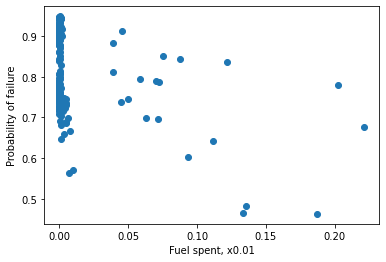

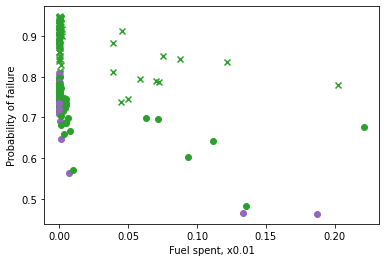

In [11]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[OBJECTIVE].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

plt.scatter(objective_model_values, 1-failure_model_values);
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("Fuel spent, x0.01");
plt.ylabel("Probability of failure");
plt.show();

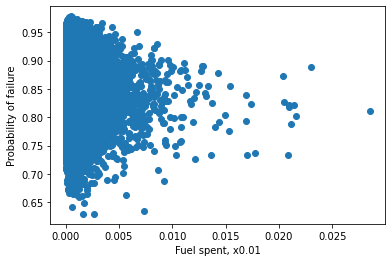

In [12]:
many_random_points = search_space.sample(100000)
objective_model_values, _ = result.models[OBJECTIVE].predict(many_random_points)
failure_model_values, _ = result.models[FAILURE].predict_y(many_random_points)

plt.scatter(objective_model_values, 1-failure_model_values)
plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Probability of failure");
plt.show();

# this fails with OOM because of how non-dominated is implemented in Trieste
# we may want to optimize it for large volumes
# points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)
# plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
# plt.xlabel("Fuel spent, x0.01")
# plt.ylabel("Probability of failure");
# plt.show();

In [13]:
result.models[OBJECTIVE]._model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.0525346492071892
GPR.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(12,)",float64,"[0.08090327, 0.08218944, 0.0740441..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.18662840197351224
GPR.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[0.48237185, 0.87093382, 0.46212477..."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[0.1716...


In [14]:
result.models[OBJECTIVE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([0.08090327, 0.08218944, 0.0740441 , 0.07409123, 0.073942  ,
       0.0740974 , 0.07427585, 0.07401172, 0.07387348, 0.07419342,
       0.07374907, 0.07394773])>

In [15]:
result.models[FAILURE]._model

name,class,transform,prior,trainable,shape,dtype,value
VGPWrapper.kernel.variance,Parameter,Softplus,,True,(),float64,0.9038484232479864
VGPWrapper.kernel.lengthscales,Parameter,Softplus,,True,"(12,)",float64,"[0.3305468, 0.33452996, 0.33576735..."
VGPWrapper.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[0.51184428, 1.19563535, 0.33553474..."
VGPWrapper.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[0....
VGPWrapper.q_mu,Parameter,Identity,,True,"(188, 1)",float64,[[-1.56421541e+00...
VGPWrapper.q_sqrt,Parameter,FillTriangular,,True,"(1, 188, 188)",float64,"[[[6.04297543e-01, 0.00000000e+00, 0.00000000e+00..."
VGPWrapper._num_data,ResourceVariable,,,False,(),float64,188.0


In [16]:
result.models[FAILURE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([0.3305468 , 0.33452996, 0.33576735, 0.34321354, 0.33307325,
       0.3405225 , 0.33783622, 0.33069914, 0.36497063, 0.33461717,
       0.19705819, 0.33865138])>

In [17]:
def probability_of_failure(point, n_tries=100):
    if not isinstance(point, np.ndarray):
        point = point.numpy()

    assert point.shape == (int(search_space.dimension),)

    n_failures = 0
    for _ in range(n_tries):
        result = demo_heuristic_lander(lunar_lander.LunarLander(), point, print_result=False)
        if result.timeout or result.has_crashed:
            n_failures += 1
    
    return n_failures / n_tries

In [18]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[OBJECTIVE].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

In [19]:
pf_points, _ = non_dominated(tf.concat([objective_model_values, 1-failure_model_values], axis=1))
pf_input_points = []
for pf_point in pf_points:
    pf_input_point = tf.boolean_mask(all_query_points, tf.equal(objective_model_values, pf_point[0])[:,0])
    if len(pf_input_point) > 1:
        pf_input_point = pf_input_point[0:1, :]
    pf_input_points.append(pf_input_point)
pf_input_points = tf.concat(pf_input_points, axis=0)

In [20]:
failure_actual_values = [
    probability_of_failure(p) for p in pf_input_points
]

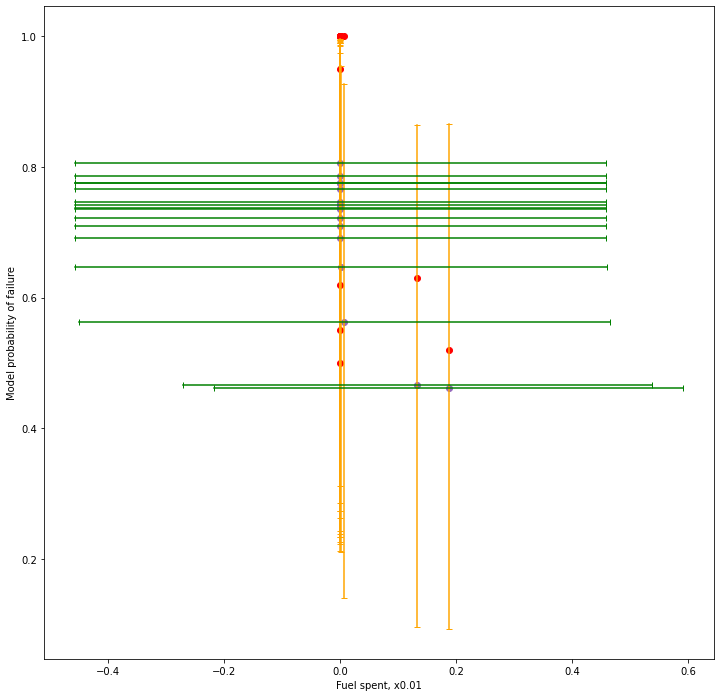

In [22]:
points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)

mean, variance = result.models[FAILURE].predict(pf_input_points)

# failure_lower_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
#     mean - 2 * tf.sqrt(variance), variance)
# failure_upper_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
#     mean + 2 * tf.sqrt(variance), variance)

failure_lower_conf_bounds = result.models[FAILURE]._model.likelihood.invlink(mean - 2 * tf.sqrt(variance))
failure_upper_conf_bounds = result.models[FAILURE]._model.likelihood.invlink(mean + 2 * tf.sqrt(variance))

mean, variance = result.models[OBJECTIVE].predict(pf_input_points)
objective_lower_conf_bounds = mean - 2 * tf.sqrt(variance)
objective_upper_conf_bounds = mean + 2 * tf.sqrt(variance)

plotting.plot_mobo_points_in_obj_space(
    points_in_objective_space,
    num_init=num_initial_points,
    only_plot_pareto=True,
    figsize=(12,12)
)
plt.scatter(pf_points[:, 0], failure_actual_values, c='r')

for i, (lower, upper) in enumerate(zip(1-failure_lower_conf_bounds, 1-failure_upper_conf_bounds)):
    plt.plot((pf_points[i].numpy()[0], pf_points[i].numpy()[0]), (lower,upper), '_-',color='orange')

for i, (lower, upper) in enumerate(zip(objective_lower_conf_bounds, objective_upper_conf_bounds)):
    plt.plot((lower,upper), (pf_points[i].numpy()[1], pf_points[i].numpy()[1]), '|-',color='green')


plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Model probability of failure");
plt.show();